## Links
* Video Presentation: https://www.youtube.com/watch?v=GEthPX15b-A
* Public GitHub Repo: https://github.com/continue-revolution/CS598-CNN-DDI
* Final Report Colab Notebook link: https://colab.research.google.com/drive/1xNVdDYWKPOvQgo88SplV70lBIdmpmYA4?usp=share_link

* **IMPORTANT NOTE**: Our final report needs to be run using the Colab notebook link. The file inside the GitHub repository is just a copy.

## Team 6
* Chengsong Zhang cz81@illinois.edu
* Lijuan Geng lijuang2@illinois.edu
* Yujia Chen ychen275@illinois.edu

# Introduction

*   Background of the problem

  There are three main types of Drug-drug interactions (DDI): synergistic (working together or cooperative), antagonistic (showing dislike or opposition) and no reaction. Predicting DDIs associated events has become increasingly important for applications in drug development and disease diagnosis.

  With advancements in machine leanring technology, methods of DDI's prediction have evolved from traditional methods, including text mining and statistical methods, to machine learning methods.

*   Paper explanation

  This work aims to study whether two drugs interact and the specific interaction types. The paper proposed a novel learning-based algorithm, named CNN-DDI, which uses convolutional neural networks (CNN) to learn the best combination of drug features and predict DDI-associated events. The CNN-DDI method contains two parts. The first part is a feature selection framework, which extracts feature interactions from drug categories, targets, pathways and enzymes as feature vectors and employ Jaccard similarity as the measurement of drug similarity. The other part is CNN-based DDI predictor, that predicts DDI-associated events based on feature pairs selected from feature selection framework.

  The results in the paper indicate that drug category is an effective new feature type to be applied in CNN-DDI. Using multiple features leads to better results than using a single feature. CNN-DDI has better performance than other state-of-art models, such as Logistic Regression, Random Forest, KNN, on the task of predicting DDIs.







# Scope of Reproducibility

We would like to reproduce and verify the following hypotheses from the paper:

1. CNN-DDI's prediction performance is improved when using drug category as a new feature.

2. Using multiple features leads to better performance of CNN-DDI than using single feature.

3. CNN-DDI performs better than other state-of-art models, such as Logistic Regression, Random Forest, KNN.

4. CNN-DDI performs better than a related work: DDIMDL.


Below shows the framework of CNN-DDI algorithm:


Downloading...
From: https://drive.google.com/uc?id=14L36NNBI-xF4Mm3ZR2MLCx4BO5M_NRPH
To: /content/framework.jpg
100%|██████████| 545k/545k [00:00<00:00, 13.7MB/s]


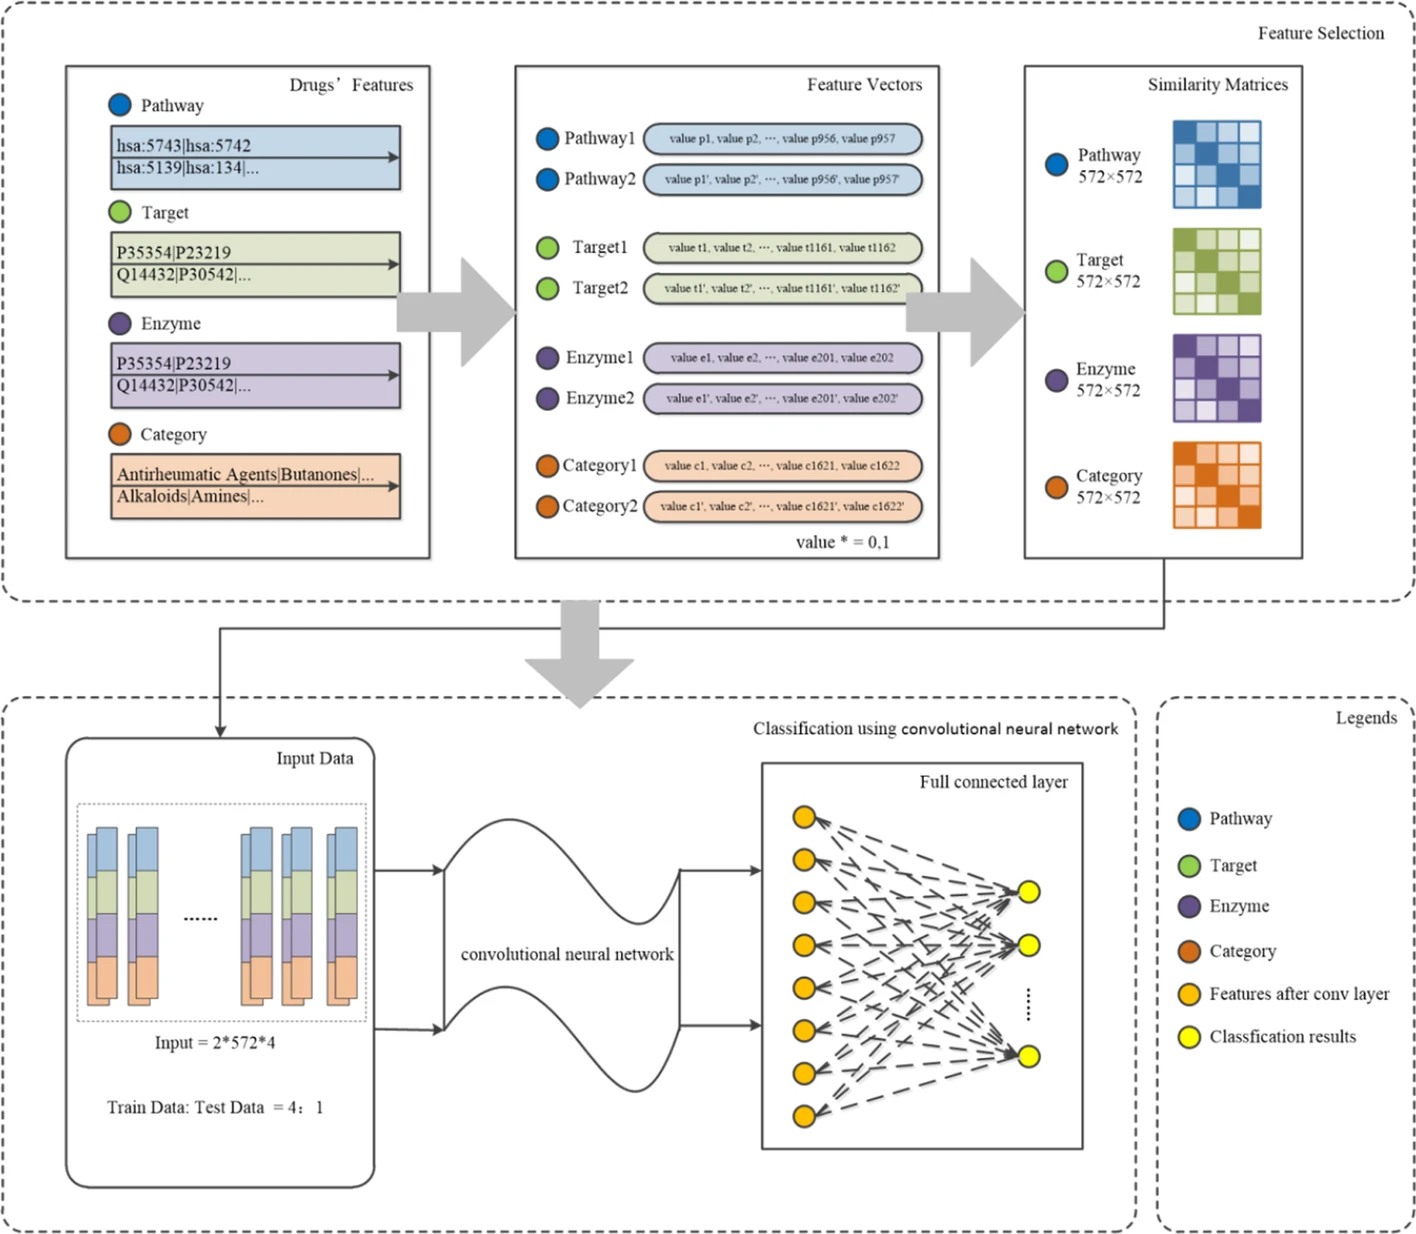

In [ ]:
import cv2
import gdown
from google.colab.patches import cv2_imshow

url_1 = 'https://drive.google.com/uc?id=14L36NNBI-xF4Mm3ZR2MLCx4BO5M_NRPH'
output1 = "framework.jpg"
file1 = gdown.download(url_1, output1)
img1=cv2.imread(file1)
cv2_imshow(img1)


# Methodology

##  Environment

  * Python version: because we use Colab notebook, the default Python version is 3.10
  * Dependencies/packages needed: Because we use Colab notebook, we import the following packages:

In [ ]:
# import  packages you need
import numpy as np
from google.colab import drive
import pandas as pd
from pandas import DataFrame
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import files
import gdown
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

##  Data

  * Source of the data: The original dataset was developed by Deng et al. [2] based on the Drugbank online database.
  * Statistics: The drug_features dataset contains information of 572 drugs and its features like pathway, target, and enzyme; the extraction dataset contains 37,264 DDIs with 65 DDI types.
  * Data process: We extract 572 drugs' drug category feature from the Drugbank online database, add it into the drug_fectures dataset, so that we have 4 features to use: pathway, target, enzyme and drug category. Then, we use one-hot encoding to transform drug features into feature vector, and use Jaccard Similarity to convert feature vector into 572 dimensions. We split the data into training and validation sets with test_size=0.2.

In [ ]:
def feature_vector(feature_name, df, similarity='jaccard'):
    def Jaccard(matrix):
        matrix = np.mat(matrix)

        numerator = matrix * matrix.T

        denominator = (
            np.ones(np.shape(matrix)) * matrix.T
            + matrix * np.ones(np.shape(matrix.T))
            - matrix * matrix.T
        )

        return numerator / denominator

    def Cosine(matrix):
        norms = np.linalg.norm(matrix, axis=1)
        matrix_normalized = matrix / norms[:, np.newaxis]
        return np.dot(matrix_normalized, matrix_normalized.T)


    def Gaussian(matrix, gamma=None):
        if gamma is None:
            norms = np.linalg.norm(matrix, axis=1)
            avg_norm = np.mean(norms)
            gamma = 1 / avg_norm**2

        squared_norms = np.sum(matrix**2, axis=1)
        squared_distance = squared_norms[:, np.newaxis] + squared_norms - \
        2 * np.dot(matrix, matrix.T)

        return np.exp(-gamma * squared_distance)

    all_feature = []
    drug_list = np.array(df[feature_name]).tolist()
    # Features for each drug, for example, when feature_name is target
    # drug_list=["P30556|P05412","P28223|P46098|……"]
    for i in drug_list:
        for each_feature in i.split("|"):
            if each_feature not in all_feature:
                all_feature.append(each_feature)  # obtain all the features
    #print("length of all feature is", len(all_feature))
    feature_matrix = np.zeros((len(drug_list), len(all_feature)), dtype=float)
    df_feature = DataFrame(
        feature_matrix, columns=all_feature
    )  # Consrtuct feature matrices with key of dataframe
    for i in range(len(drug_list)):
        for each_feature in df[feature_name].iloc[i].split("|"):
            df_feature[each_feature].iloc[i] = 1

    df_feature = np.array(df_feature)
    if similarity == 'jaccard':
        sim_matrix = np.array(Jaccard(df_feature))
    elif similarity == 'cosine':
        sim_matrix = Cosine(df_feature)
    elif similarity == 'gaussian':
        sim_matrix = Gaussian(df_feature)
    else:
        raise ValueError("Unknown similarity measure")

    #print(feature_name + " len is:" + str(len(sim_matrix[0])))
    return sim_matrix

def prepare(df_drug, feature_list, mechanism, action, drugA, drugB, \
similarity='jaccard'):
    d_label = {}
    d_feature = {}

    # Transfrom the interaction event to number
    d_event = []
    for i in range(len(mechanism)):
        d_event.append(mechanism[i] + " " + action[i])

    count = {}
    for i in d_event:
        if i in count:
            count[i] += 1
        else:
            count[i] = 1
    event_num = len(count)
    list1 = sorted(count.items(), key=lambda x: x[1], reverse=True)
    for i in range(len(list1)):
        d_label[list1[i][0]] = i

    vector = []
    for i in feature_list:
        #vector = np.hstack((vector, feature_vector(i, df_drug, vector_size)))
        vector.append(feature_vector(i, df_drug, similarity))
    vector = np.stack(vector, axis=-1)
    # Transfrom the drug ID to feature vector
    for i in range(len(np.array(df_drug["name"]).tolist())):
        d_feature[np.array(df_drug["name"]).tolist()[i]] = vector[i]

    # Use the dictionary to obtain feature vector and label
    new_feature = []
    new_label = []

    for i in range(len(d_event)):
        temp = np.concatenate(
            [d_feature[drugA[i]][None], d_feature[drugB[i]][None]], axis=0)
        new_feature.append(temp)
        new_label.append(d_label[d_event[i]])

    new_feature = np.array(new_feature)
    new_label = np.array(new_label)

    return new_feature, new_label, event_num


url1 = 'https://drive.google.com/uc?id=1EQp5p2bPloVnLq28G_G94xs2SrM-2Hhv'
output1 = "drug_features.csv"
file1 = gdown.download(url1, output1)
df_drug = pd.read_csv(file1)

url2 = 'https://drive.google.com/uc?id=1ZjzdxeOam8qwslBVmWKaWcZ6t5UqnXQ9'
output2 = "extraction.csv"
file2 = gdown.download(url2, output2)
extraction = pd.read_csv(file2)

print(df_drug.shape)
print(extraction.shape)
#df_drug = pd.read_csv("drug_features.csv")
#extraction = pd.read_csv("extraction.csv")
mechanism = extraction["mechanism"]
action = extraction["action"]
drugA = extraction["drugA"]
drugB = extraction["drugB"]
feature_list = ["pathway", "target", "enzyme", "category"]
new_feature, new_label, event_num = \
prepare(df_drug, feature_list, mechanism, action, drugA, drugB, \
similarity='jaccard')
new_feature = torch.tensor(new_feature, dtype=torch.float32)


Downloading...
From: https://drive.google.com/uc?id=1EQp5p2bPloVnLq28G_G94xs2SrM-2Hhv
To: /content/drug_features.csv
100%|██████████| 841k/841k [00:00<00:00, 11.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZjzdxeOam8qwslBVmWKaWcZ6t5UqnXQ9
To: /content/extraction.csv
100%|██████████| 2.93M/2.93M [00:00<00:00, 22.0MB/s]


(572, 8)
(37264, 5)


Below shows the first 10 rows of drug_features table and extraction table:

Downloading...
From: https://drive.google.com/uc?id=1C5MLreV88LA6ySATgsZCwXpxhWXo3CZZ
To: /content/drug.png
100%|██████████| 137k/137k [00:00<00:00, 4.60MB/s]


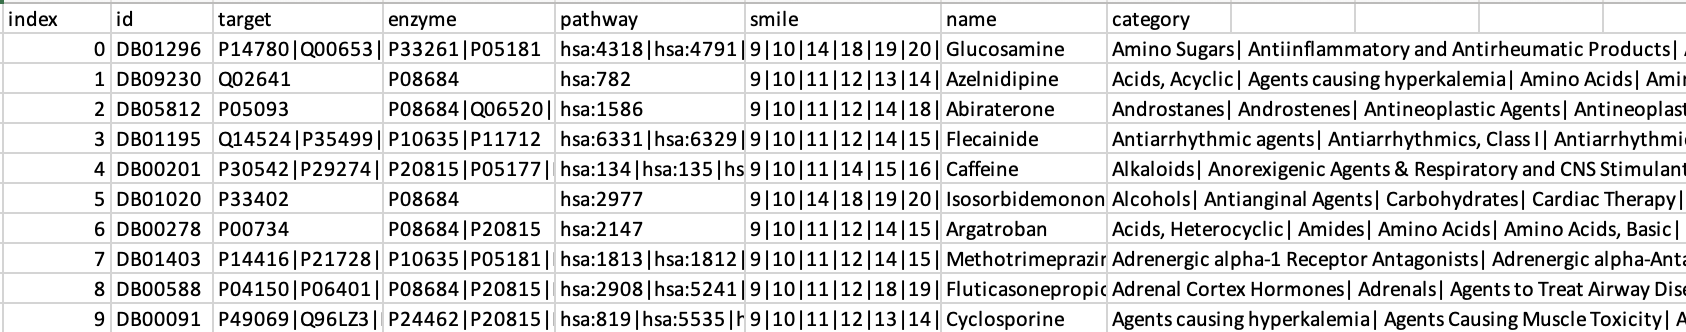

Downloading...
From: https://drive.google.com/uc?id=1gpLGCl4MUII_grtC5WZJ5AnND-UBS-pC
To: /content/extraction.png
100%|██████████| 80.8k/80.8k [00:00<00:00, 3.89MB/s]


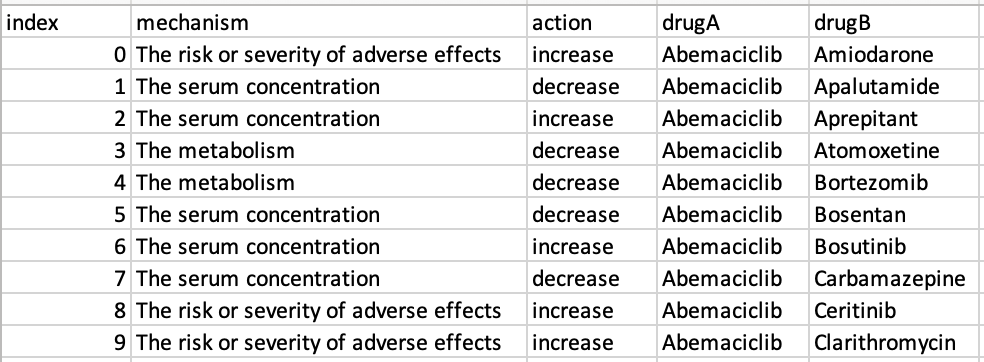

In [ ]:
url4 = 'https://drive.google.com/uc?id=1C5MLreV88LA6ySATgsZCwXpxhWXo3CZZ'
output4 = "drug.png"
file_4 = gdown.download(url4, output4)
img_4=cv2.imread(file_4)
cv2_imshow(img_4)

url5 = 'https://drive.google.com/uc?id=1gpLGCl4MUII_grtC5WZJ5AnND-UBS-pC'
output5 = "extraction.png"
file_5 = gdown.download(url5, output5)
img_5=cv2.imread(file_5)
cv2_imshow(img_5)

##   Model

 Model architecture: According to the original paper [1], our model is a CNN model, including 5 convolutional layers and 2 fully-connected layers. For convolutional layers, the filters’ numbers are 64, 128, 128, 128 and 256, and the kernel size is 3*1. In addition, we add a residual block between two convolutional layers, which adds the output of conv2 to the output of conv3_2. The activation function we use is Leaky ReLU for the 5 convolutional layers and 1 fully-connected layer, for the last fully-connected layer we use Softmax.


In [ ]:
class CNNDDI(nn.Module):
    def __init__(self, num_of_features=4):
        super(CNNDDI, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, (3, 1), padding=(1, 0))
        self.conv2 = nn.Conv2d(64, 128, (3, 1), padding=(1, 0))
        self.conv3_1 = nn.Conv2d(128, 128, (3, 1), padding=(1, 0))
        self.conv3_2 = nn.Conv2d(128, 128, (3, 1), padding=(1, 0))
        self.conv4 = nn.Conv2d(128, 256, (3, 1), padding=(1, 0))
        # Adjust feature_size based on your input dimensions
        self.fc1 = nn.Linear(256 * 572 * num_of_features, 256)
        self.fc2 = nn.Linear(256, 65)  # Assuming 65 DDI types

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        identity = x
        x = F.leaky_relu(self.conv3_1(x), negative_slope=0.2)
        x = self.conv3_2(x)
        x += identity
        x = F.leaky_relu(x, negative_slope=0.2)
        x = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = self.fc2(x)
        return x


Below shows the structure of prediction model; and the convolution layers of CNN-DDI

Downloading...
From: https://drive.google.com/uc?id=1j7y2Z-hdeyO3DqGhvr621MSGFP-Z_XmB
To: /content/Model.jpg
100%|██████████| 160k/160k [00:00<00:00, 4.66MB/s]


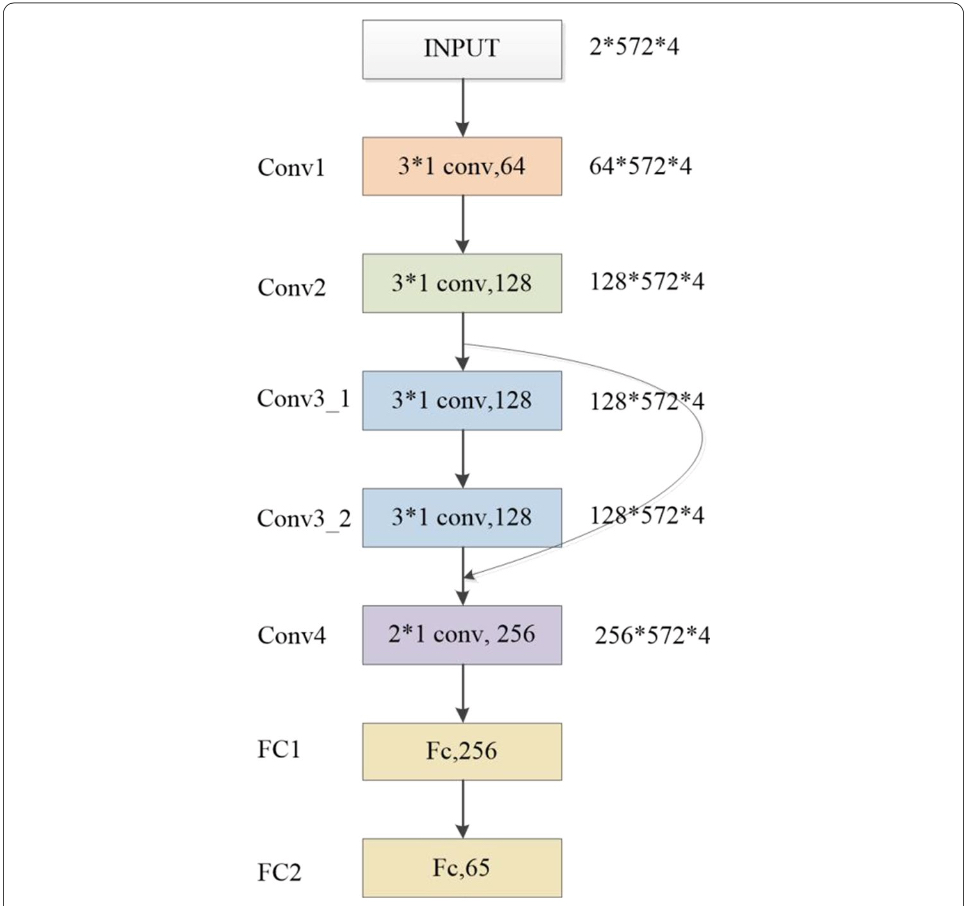

Downloading...
From: https://drive.google.com/uc?id=14Amdu0p6fcTKrK-1bMqgP-eSA0G_P7pU
To: /content/Size.jpg
100%|██████████| 70.3k/70.3k [00:00<00:00, 3.65MB/s]


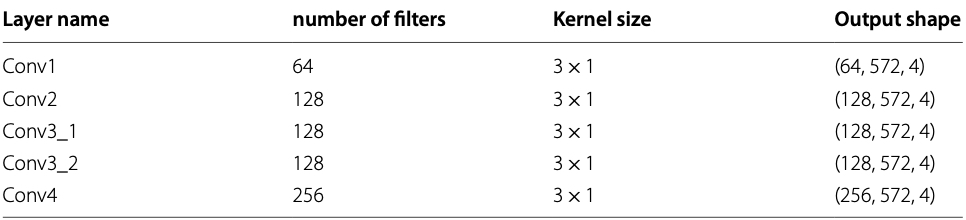

In [ ]:
url_2 = 'https://drive.google.com/uc?id=1j7y2Z-hdeyO3DqGhvr621MSGFP-Z_XmB'
output2 = "Model.jpg"
file2 = gdown.download(url_2, output2)
img2=cv2.imread(file2)
cv2_imshow(img2)

url_3 = 'https://drive.google.com/uc?id=14Amdu0p6fcTKrK-1bMqgP-eSA0G_P7pU'
output3 = "Size.jpg"
file3 = gdown.download(url_3, output3)
img3=cv2.imread(file3)
cv2_imshow(img3)

##   Training

 * Hyperparams:
  * learning rate = 0.001
  * batch size = 32
  * dropout: none
  * number of convolutional layers = 5
  * number of fully-connected layers = 2
 * Computational requirements:
  * type of hardware: NVIDIA GeForce RTX 4090 GPU
  * average runtime for each epoch: 22s
  * number of training epochs: 50, each model takes about 18 minutes to train
  * total number of trials: we trained 21 models in total including ablation studies
  * GPU hrs used: we trained 21 models, each has 50 epochs, and each epoch takes 22s to train, so the total GPU hrs is 6.3 hours
 * Training objectives: For the loss function, we use focal loss based on what the paper provided, because focal loss is more useful for training imbalanced datasets. For the optimizer, we use Adam optimizer.
 * **IMPORTANT NOTE**: As our model's training code takes a long time to run in Colab, even a single epoch's execution time is much longer than the 8 minute time limit. Therefore, we have to set num_epochs = 0 in the training part for this notebook. If you would like to observe the actual execution of the trainig code, please set num_epochs = 1, but again this could take a long time. In the acutal training, we used num_epochs = 50. Please find the complete training result in the Result section.

In [ ]:
class DrugInteractionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# Split the data into training and validation sets
features_train, features_val, labels_train, labels_val = train_test_split(
    new_feature, new_label, test_size=0.2, random_state=42
)

# Create dataset objects
train_dataset = DrugInteractionDataset(features_train, labels_train)
val_dataset = DrugInteractionDataset(features_val, labels_val)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class focal_loss(nn.Module):
    def __init__(self, gamma=2):
        super(focal_loss, self).__init__()
        self.gamma = gamma

    def forward(self, preds, labels):
        labels = labels[..., None]

        preds_logsoft = F.log_softmax(preds, dim=1)
        preds_softmax = torch.exp(preds_logsoft)

        preds_softmax = preds_softmax.gather(1, labels)
        preds_logsoft = preds_logsoft.gather(1, labels)

        loss=-torch.mul(torch.pow((1-preds_softmax),self.gamma),preds_logsoft)

        loss = loss.mean()

        return loss

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

<ipython-input-7-9b973a0977fd>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)


##   Evaluation

 * Metrics descriptions:
  * Accuracy: Measures proportion of correct predictions across the dataset.
  * Precision: Measures proportion of true positive predictions among all positive predictions.
  * Recall: Measures proportion of true positive predictions among all actual positive instances.
  * F1: Calculated as the harmonic mean of precision and recall.
  * AUC: Compute area under ROC curve from prediction scores.
  * AUPR: Compute average precision from prediction scores.
  

In [ ]:
def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(
                torch.nn.functional.softmax(outputs.data, 1).cpu().numpy())

    all_predicted = np.array(all_predicted)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    val_loss = total_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    precision = precision_score(
        all_labels, all_predicted, average='macro',zero_division=0)
    recall = recall_score(
        all_labels, all_predicted, average='macro',zero_division=0)
    f1 = f1_score(all_labels, all_predicted, average='macro',zero_division=0)
    roc_auc = roc_auc_score(label_binarize(all_labels, classes=range(65))[:,1],\
                            all_probs[:,1], multi_class='ovo', average='micro')
    aupr = average_precision_score(label_binarize(
        all_labels, classes=range(65))[:,1], all_probs[:,1], average='micro')

    return val_loss, val_accuracy, precision, recall, f1, roc_auc, aupr


def save_checkpoint(model, optimizer, epoch, filename):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, filename)
    print(f"Saved checkpoint: {filename}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNDDI().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = focal_loss()

num_epochs = 0
checkpoint_interval = 1

for epoch in tqdm(range(num_epochs)):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy, precision, recall, f1, roc_auc, aupr = validate(
        model, device, val_loader, criterion)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, \
Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, \
Precision: {precision:.4f}, recall: {recall:.4f}, F1: {f1:.4f}, \
AUC: {roc_auc:.4f}, AUPR: {aupr:.4f}')

    if (epoch + 1) % checkpoint_interval == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(
        model, optimizer, epoch + 1, f'checkpoints/cnn_ddi_epoch_{epoch+1}.pt')

0it [00:00, ?it/s]


# Results

* We use batch_size = 32 and num_epochs = 50 for training, and after 50 epochs, our Validation Accuracy = 0.8881, which is pretty close to paper's result (accuracy = 0.8871).
* We have attached part of our training result below for reference. The complete training results can be found in the Github repo: https://github.com/continue-revolution/CS598-CNN-DDI/blob/conrevo0/training.ipynb
* Also, we have saved checkpoints in cloud and can load the checkpoint to compare our results, the complete checkpoints can be found at https://huggingface.co/conrevo/CS598-CNN-DDI/tree/main . Below is an example of loading checkpoint, which shows that all keys matched successfully. Also we can get the metrics result by loading the pre-trained model.
* We have plotted our validation loss and training loss, which shows the training loss is relatively low, and the validation loss is relatively high.
* We also plotted our validation accuracy for the 50 epochs as below.

* **IMPORTANT NOTE**: Loading the checkpoint takes about 1 minute.

In [ ]:
cnn_ddi = CNNDDI()
state_dict = torch.hub.load_state_dict_from_url(
"https://huggingface.co/conrevo/CS598-CNN-DDI/resolve/main/table_1/jaccard/\
cnn_ddi_epoch_jaccard_50.pt",
model_dir="checkpoints",map_location=torch.device('cpu'))
cnn_ddi.load_state_dict(state_dict["state_dict"])

Downloading: "https://huggingface.co/conrevo/CS598-CNN-DDI/resolve/main/table_1/jaccard/cnn_ddi_epoch_jaccard_50.pt" to checkpoints/cnn_ddi_epoch_jaccard_50.pt
100%|██████████| 1.68G/1.68G [00:19<00:00, 90.4MB/s]


<All keys matched successfully>

* **IMPORTANT NOTE**: Loading the metrics result of the pre-trained model takes 6-8 minutes.

In [ ]:
for epoch in tqdm([50]):
    val_loss, val_accuracy, precision, recall, f1, roc_auc, aupr = validate(
        cnn_ddi.to(device), device, val_loader, criterion)
    print(f'Epoch {epoch}, Validation Loss: {val_loss:.4f}, \
Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, \
recall: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}, AUPR: {aupr:.4f}')

100%|██████████| 1/1 [05:43<00:00, 343.46s/it]

Epoch 50, Validation Loss: 3.0103, Validation Accuracy: 0.8881, Precision: 0.8205, recall: 0.8336, F1: 0.8104, AUC: 0.9883, AUPR: 0.9571


Downloading...
From: https://drive.google.com/uc?id=1GcBCiCVCBdTdglESWGtcfr6n4dqC_VUc
To: /content/result1.png
100%|██████████| 269k/269k [00:00<00:00, 5.13MB/s]


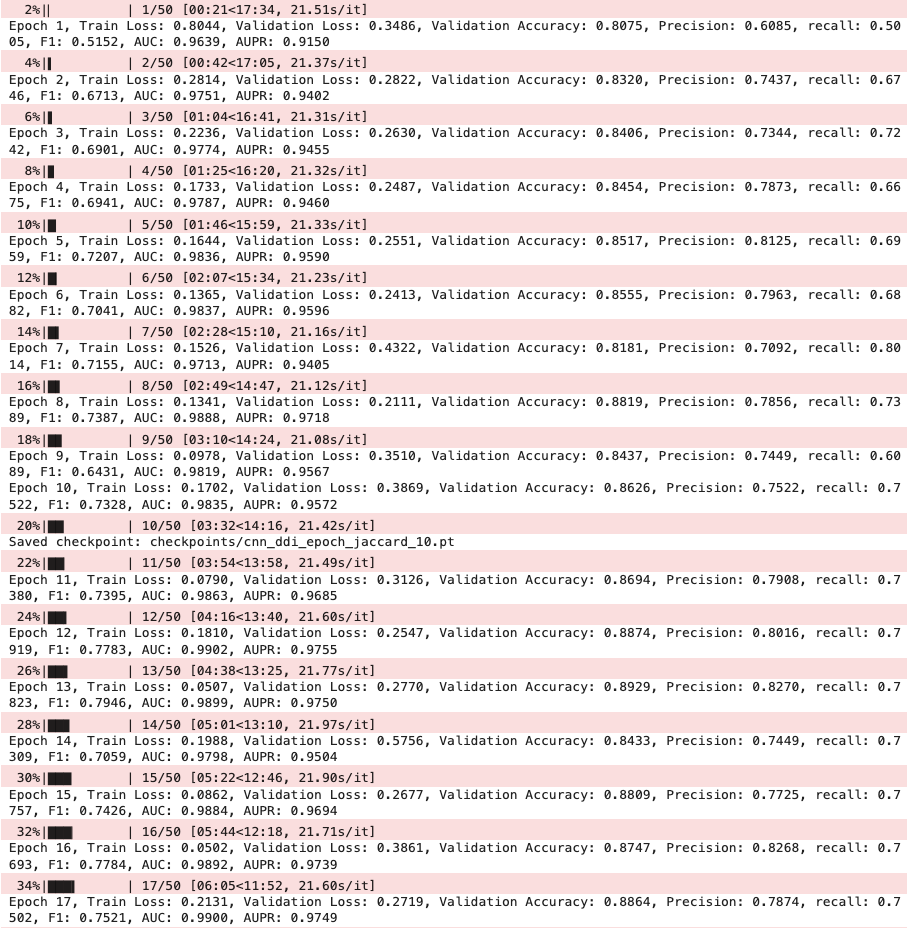

Downloading...
From: https://drive.google.com/uc?id=1HWj0dbYpkejt0m4OiGOYO3NCi3xcPw_V
To: /content/result2.png
100%|██████████| 280k/280k [00:00<00:00, 5.52MB/s]


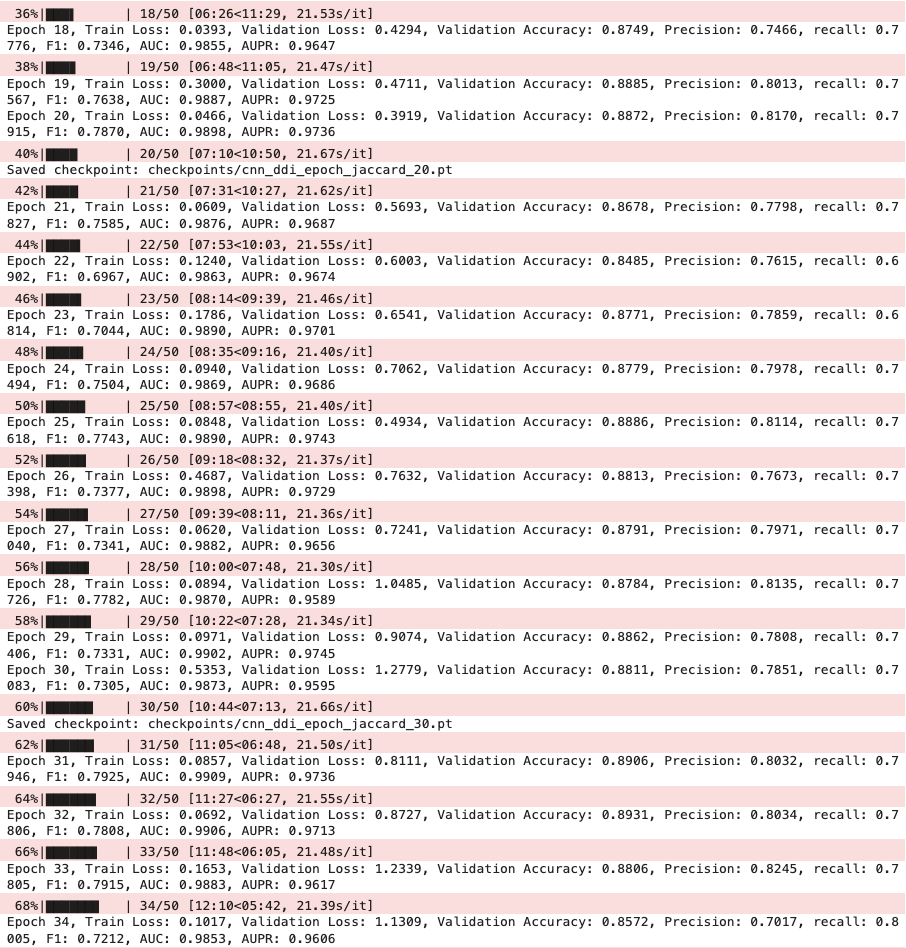

Downloading...
From: https://drive.google.com/uc?id=1ZfzTbUg3VLieTuMyDOGMaDKq_uo6KRUK
To: /content/result3.png
100%|██████████| 264k/264k [00:00<00:00, 5.58MB/s]


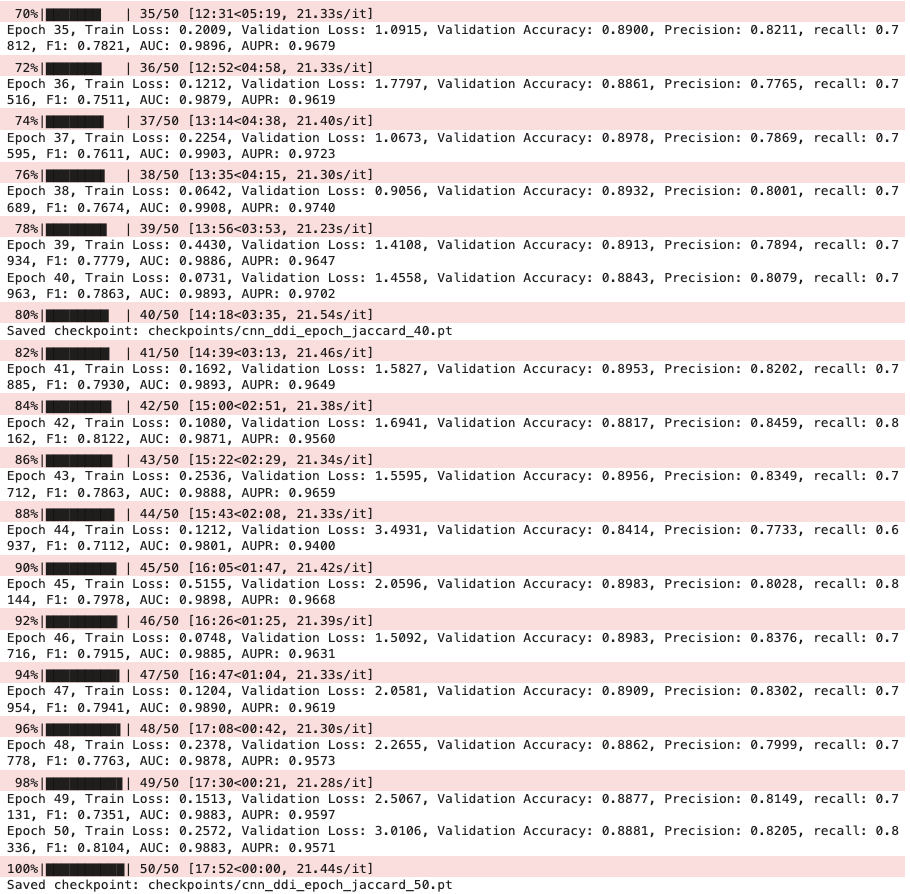

In [ ]:

url_4 = 'https://drive.google.com/uc?id=1GcBCiCVCBdTdglESWGtcfr6n4dqC_VUc'
output4 = "result1.png"
file4 = gdown.download(url_4, output4)
img4=cv2.imread(file4)
cv2_imshow(img4)


url_5 = 'https://drive.google.com/uc?id=1HWj0dbYpkejt0m4OiGOYO3NCi3xcPw_V'
output5 = "result2.png"
file5 = gdown.download(url_5, output5)
img5=cv2.imread(file5)
cv2_imshow(img5)

url_6 = 'https://drive.google.com/uc?id=1ZfzTbUg3VLieTuMyDOGMaDKq_uo6KRUK'
output6 = "result3.png"
file6 = gdown.download(url_6, output6)
img6=cv2.imread(file6)
cv2_imshow(img6)



Downloading...
From: https://drive.google.com/uc?id=1fUfGzXACtqjfUPkTVTWjEHMNLz5E1y1O
To: /content/result.txt
100%|██████████| 1.24k/1.24k [00:00<00:00, 2.19MB/s]


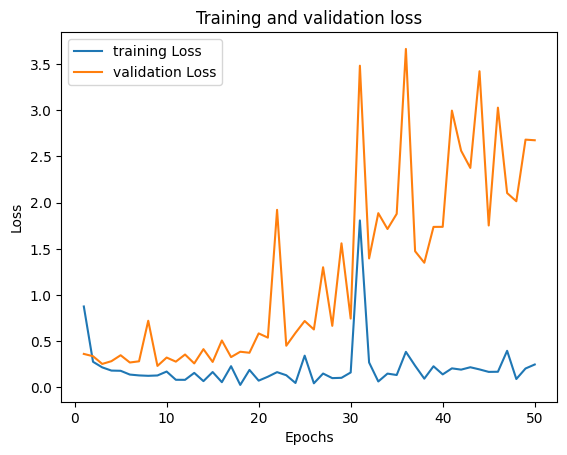

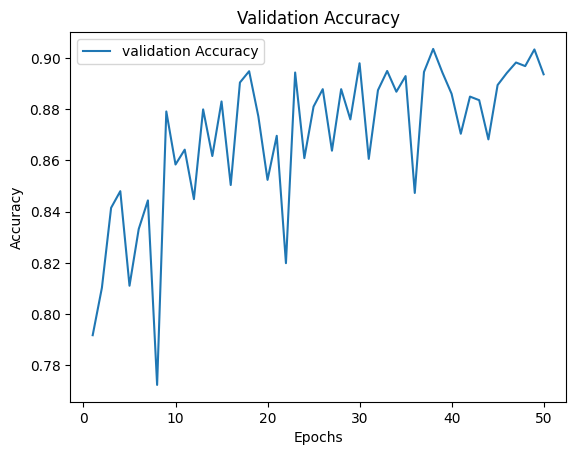

In [ ]:
import matplotlib.pyplot as plt

url3 = 'https://drive.google.com/uc?id=1fUfGzXACtqjfUPkTVTWjEHMNLz5E1y1O'
output_3 = "result.txt"
file_3 = gdown.download(url3, output_3)
df_result = pd.read_csv(file_3)

lines = df_result.plot.line(x='Epoch', y=['TrainLoss', 'ValidationLoss'])
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training Loss', 'validation Loss'], loc='upper left')
plt.show()

lines = df_result.plot.line(x='Epoch', y=['ValidationAccuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['validation Accuracy'], loc='upper left')
plt.show()

## Ablation Study 1: Comparison with model trained with different similarity measures

* Orignally we use Jaccard similarity to train the model, for ablation study 1, we replace Jaccard similarity measure with Cosine similarity and Gaussian similarity to evaluate how similarity measure affects model's performance.
* We define three similarity measures in the feature_vector function using def Jaccard(matrix) / def Cosine(matrix) / def Gaussian(matrix, gamma=None), and used for loop to iterate through these three silimarity measures.
* The code below is what we used for our ablation study 1, here we set num_epochs = 0 just to show the training process, in real we set num_epochs = 50. The complete training results can be found in the Github repo: https://github.com/continue-revolution/CS598-CNN-DDI/blob/conrevo0/training.ipynb
* **Result:** Table 1 shows the performance of CNN-DDI using three similarity measures. We can see that Gaussian similarity has the highest accuracy, while Jaccard similarity has the highest AUPR, AUC, F1, Precision and Recall. Based on these metrics, we choose Jaccard similarity as the measure in our model.
* **Discussion:** When comparing model performances, we should consider all the performance metrics. While Gaussian has higher accuracy, Jaccard's other 5 metrics are all higher than Gaussian, which makes Jaccard a better similarity measure to be used in our model. Even though the original paper's results show that CNN-DDI has similar performance using three similarity measures, our reproduced result exhibits better performance with Jaccard similarity.


In [ ]:
batch_size = 32
num_epochs = 0
checkpoint_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for similarity in ["jaccard", "cosine", "gaussian"]:
    print(f"Similarity measure: {similarity}")
    new_feature, new_label, event_num = prepare(
        df_drug, feature_list, mechanism, action, drugA, drugB,\
        similarity=similarity)
    new_feature = torch.tensor(new_feature, dtype=torch.float32)
    features_train, features_val, labels_train, labels_val = train_test_split(
        new_feature, new_label, test_size=0.2, random_state=42
    )

    # Create dataset objects
    train_dataset = DrugInteractionDataset(features_train, labels_train)
    val_dataset = DrugInteractionDataset(features_val, labels_val)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CNNDDI().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = focal_loss()

    for epoch in tqdm(range(num_epochs)):
        train_loss = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy, precision, recall, f1, roc_auc, aupr = validate(
            model, device, val_loader, criterion)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, \
Validation Loss: {val_loss:.4f}, \
Validation Accuracy: {val_accuracy:.4f}, \
Precision: {precision:.4f}, recall: {recall:.4f}, F1: {f1:.4f}, \
AUC: {roc_auc:.4f}, AUPR: {aupr:.4f}')

        if (epoch + 1) % checkpoint_interval == 0 or (epoch + 1) == num_epochs:
            save_checkpoint(model, optimizer, epoch + 1,\
            f'checkpoints/cnn_ddi_epoch_{similarity}_{epoch+1}.pt')

Similarity measure: jaccard


<ipython-input-7-9b973a0977fd>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
0it [00:00, ?it/s]


Similarity measure: cosine


0it [00:00, ?it/s]


Similarity measure: gaussian


0it [00:00, ?it/s]


Downloading...
From: https://drive.google.com/uc?id=1hmaE5U2sOwqFh0Iy4R_SHljLuBIKwDfu
To: /content/Table1.png
100%|██████████| 70.1k/70.1k [00:00<00:00, 3.86MB/s]


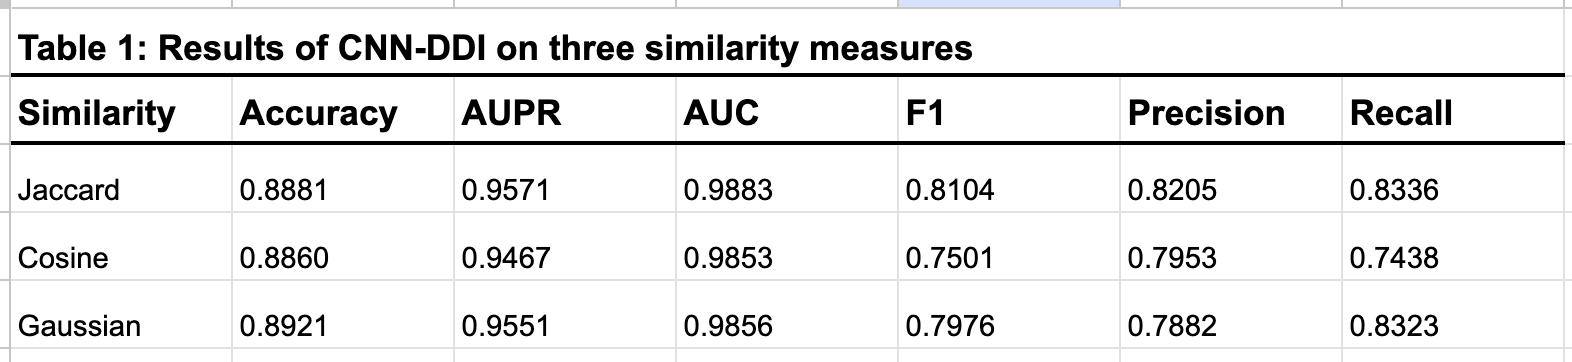

In [ ]:
url_7 = 'https://drive.google.com/uc?id=1hmaE5U2sOwqFh0Iy4R_SHljLuBIKwDfu'
output7 = "Table1.png"
file7 = gdown.download(url_7, output7)
img7=cv2.imread(file7)
cv2_imshow(img7)

## Ablation Study 2: Comparison with models trained with different feature selection

* Originally, we use four features to train our model. For ablation study 2, we train our model with different feature selections and compare performances.
* There are four features in the feature_list: P - pathway, T - target, E - enzyme, and C - category. We itereate through all different combinations of the features in the feature_list, and produce results for each combination. For example, in Table 2, "T+P+C" means the model was trained with target+pathway+category as the feature combination.  
* The code below is what we used for our ablation study 2, here we set num_epochs = 0 just to show the training process, in real we set num_epochs = 50. The complete training results can be found in the Github repo: https://github.com/continue-revolution/CS598-CNN-DDI/blob/conrevo0/training.ipynb
* **Result:** From Table 2, we can observe that "C" (category) has the highest accuracy, AUPR and AUC, "E+C" (enzyme+category) has the highest precision, and "T+P+E+C" (target+pathway+enzyme+category) has the highest recall and F1 score.
* **Discussion:** The result provides many insights on how different features or feature combinations affect the model performance:

  *   When using just one feature, C (category) leads to better performance than using T, P, or E alone.
  *   When using a combination of two or more features, "[list of other features] + C" have better performance than using just [list of other features]. For example, E+C > E, P+E+C > P+E.
  * These clearly indicate the importance of drug category as a feature to improve CNN-DDI's prediction performance.
  * We can also tell that the model's performance is improved when multiple features are used instead of a single feature.
  * The overall performance of the model using a combination of all four features is a winner, which mostly aligns with the results of the original paper. In the original paper, T+P+E+C has the best metrics in Accuracy, AUPR, AUC, Precision, and the 2nd best in F1 and Recall. Our reproduction result in Table 2 shows T+P+E+C has the highest F1 and Recall, but is the 2nd or 3rd best for other metrics.
  * After comparing with the original paper, we found that the original paper extracted 1622 types of drug category from the Drugbank website in December 2020, while our team extracted 1803 types of drug category from the Drugbank website in March 2024. Apparently the Drugbank website has updated the drug category for the 572 drugs since then, which makes our feature "category" an even better feature that outperforms the previous "category" from the paper. Therefore, our reproduction result is slightly different from the original paper due to an updated dataset.

In [ ]:
import itertools

feature_list = ["pathway", "target", "enzyme", "category"]

# Generate all combinations for different lengths
all_combinations = []
for r in range(1, len(feature_list) + 1):
    combinations = list(itertools.combinations(feature_list, r))
    all_combinations.extend(combinations)

# Train models for all combinations
batch_size = 32
num_epochs = 0
checkpoint_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for combination in all_combinations:
    print(f"Feature combination: {combination}")
    new_feature, new_label, event_num = prepare(
        df_drug, combination, mechanism, action, drugA, drugB,\
        similarity="jaccard")
    new_feature = torch.tensor(new_feature, dtype=torch.float32)
    features_train, features_val, labels_train, labels_val = train_test_split(
        new_feature, new_label, test_size=0.2, random_state=42
    )

    # Create dataset objects
    train_dataset = DrugInteractionDataset(features_train, labels_train)
    val_dataset = DrugInteractionDataset(features_val, labels_val)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CNNDDI(num_of_features=len(combination)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = focal_loss()

    for epoch in tqdm(range(num_epochs)):
        train_loss = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy, precision, recall, f1, roc_auc, aupr = validate(
            model, device, val_loader, criterion)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, \
Validation Loss: {val_loss:.4f}, \
Validation Accuracy: {val_accuracy:.4f}, \
Precision: {precision:.4f}, recall: {recall:.4f}, F1: {f1:.4f}, \
AUC: {roc_auc:.4f}, AUPR: {aupr:.4f}')

        if (epoch + 1) % checkpoint_interval == 0 or (epoch + 1) == num_epochs:
            combination_str = "_".join(combination)
            save_checkpoint(model, optimizer, epoch + 1,\
            f'checkpoints/cnn_ddi_epoch_{epoch+1}_{combination_str}.pt')

Feature combination: ('pathway',)


<ipython-input-7-9b973a0977fd>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
0it [00:00, ?it/s]


Feature combination: ('target',)


0it [00:00, ?it/s]


Feature combination: ('enzyme',)


0it [00:00, ?it/s]


Feature combination: ('category',)


0it [00:00, ?it/s]


Feature combination: ('pathway', 'target')


0it [00:00, ?it/s]


Feature combination: ('pathway', 'enzyme')


0it [00:00, ?it/s]


Feature combination: ('pathway', 'category')


0it [00:00, ?it/s]


Feature combination: ('target', 'enzyme')


0it [00:00, ?it/s]


Feature combination: ('target', 'category')


0it [00:00, ?it/s]


Feature combination: ('enzyme', 'category')


0it [00:00, ?it/s]


Feature combination: ('pathway', 'target', 'enzyme')


0it [00:00, ?it/s]


Feature combination: ('pathway', 'target', 'category')


0it [00:00, ?it/s]


Feature combination: ('pathway', 'enzyme', 'category')


0it [00:00, ?it/s]


Feature combination: ('target', 'enzyme', 'category')


0it [00:00, ?it/s]


Feature combination: ('pathway', 'target', 'enzyme', 'category')


0it [00:00, ?it/s]


Downloading...
From: https://drive.google.com/uc?id=1UozwcQqT34O9UTzAuzg5P4DLpaBqsMCB
To: /content/Table2.png
100%|██████████| 181k/181k [00:00<00:00, 4.96MB/s]


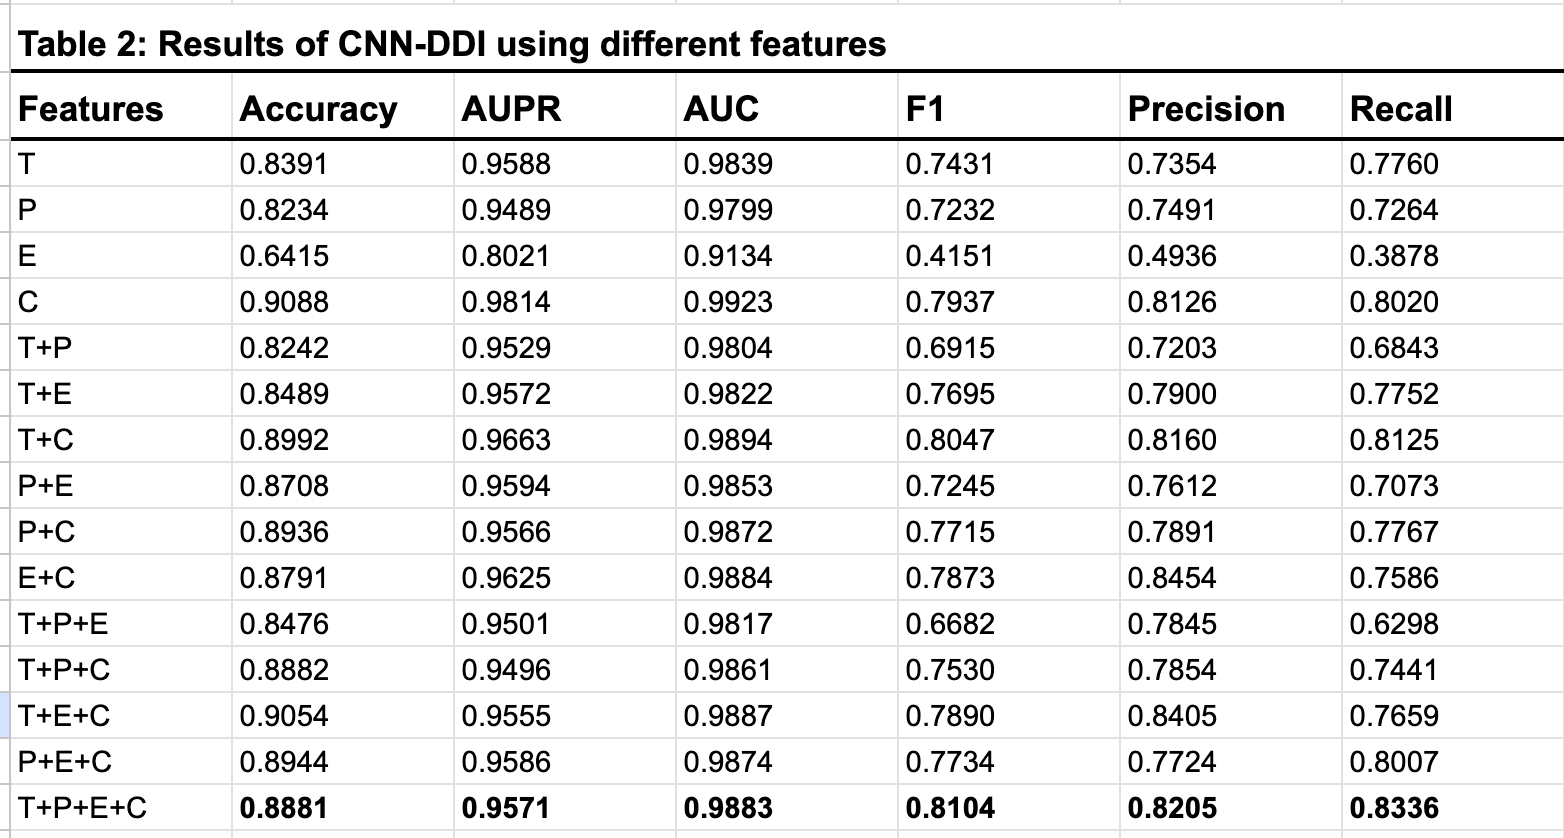

In [ ]:
url_8 = 'https://drive.google.com/uc?id=1UozwcQqT34O9UTzAuzg5P4DLpaBqsMCB'
output8 = "Table2.png"
file8 = gdown.download(url_8, output8)
img8=cv2.imread(file8)
cv2_imshow(img8)

## Ablation Study 3: Comparison with model trained without "residual block"

* The original paper defined a CNN model with a residual block between two convolutional layers, which adds the output of conv2 to the output of conv3_2. The residual block is put in place to strengthen the correlation of multi-layer features. For our ablation study 3, we remove the residual block from our model and evaluate the impacts on performance.
* We create a new class called CNNDDI_no_residual to distinguish with our original CNN-DDI model, and we use logger to track the runtime of the model.
* The code below is what we used for our ablation study 3, here we set num_epochs = 0 just to show the training process, in real we set num_epochs = 50. The complete training results can be found in the Github repo: https://github.com/continue-revolution/CS598-CNN-DDI/blob/conrevo0/training.ipynb
* **Result:** From Table 3, we can see that after removing the residual block from the model, precision/recall/F1 have significantly degraded (in the scale of 0.1 and 0.01). On the other hand, Accuracy, AUC and AUPR stays almost the same (negligible difference in the scale of 0.001).
* **Discussion:** The performance of our model is sensitive to the removal of the residual block, especially for Precision, Recall, and F1. This might be related to the data balance level used in training. As far as we understand, because our training data is more balanced, the performance of our model is better represented by F1, precision, and recall. This also explains why we see a more obvious degradation in these metrics after removing the residual block.

In [ ]:
class CNNDDI_no_residual(nn.Module):
    def __init__(self, num_of_features=4):
        super(CNNDDI_no_residual, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, (3, 1), padding=(1, 0))
        self.conv2 = nn.Conv2d(64, 128, (3, 1), padding=(1, 0))
        self.conv3_1 = nn.Conv2d(128, 128, (3, 1), padding=(1, 0))
        self.conv3_2 = nn.Conv2d(128, 128, (3, 1), padding=(1, 0))
        self.conv4 = nn.Conv2d(128, 256, (3, 1), padding=(1, 0))
        # Adjust feature_size based on your input dimensions
        self.fc1 = nn.Linear(256 * 572 * num_of_features, 256)
        self.fc2 = nn.Linear(256, 65)  # Assuming 65 DDI types

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        # identity = x
        x = F.leaky_relu(self.conv3_1(x), negative_slope=0.2)
        x = self.conv3_2(x)
        # x += identity
        x = F.leaky_relu(x, negative_slope=0.2)
        x = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = self.fc2(x)
        return x

import copy
import logging
import sys

class ColoredFormatter(logging.Formatter):
    COLORS = {
        "DEBUG": "\033[0;36m",  # CYAN
        "INFO": "\033[0;32m",  # GREEN
        "WARNING": "\033[0;33m",  # YELLOW
        "ERROR": "\033[0;31m",  # RED
        "CRITICAL": "\033[0;37;41m",  # WHITE ON RED
        "RESET": "\033[0m",  # RESET COLOR
    }

    def format(self, record):
        colored_record = copy.copy(record)
        levelname = colored_record.levelname
        seq = self.COLORS.get(levelname, self.COLORS["RESET"])
        colored_record.levelname = f"{seq}{levelname}{self.COLORS['RESET']}"
        return super().format(colored_record)


# Create a new logger
logger = logging.getLogger("CNN-DDI")
logger.propagate = False

# Add handler if we don't have one.
if not logger.handlers:
    handler = logging.StreamHandler(sys.stdout)
    handler.setFormatter(
        ColoredFormatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    )
    logger.addHandler(handler)

# Configure logger
loglevel_string = "INFO"
if not loglevel_string:
    loglevel_string = "INFO"
loglevel = getattr(logging, loglevel_string.upper(), None)
logger.setLevel(loglevel)

batch_size = 32
num_epochs = 0
checkpoint_interval = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, model_class in enumerate([CNNDDI_no_residual, CNNDDI]):
    model_class_str = "CNNDDI" if idx == 1 else "CNNDDI_no_residual"
    logger.info(f"Model Arch: {model_class_str}")
    new_feature, new_label, event_num = prepare(
        df_drug, feature_list, mechanism, action, drugA, drugB)
    new_feature = torch.tensor(new_feature, dtype=torch.float32)
    features_train, features_val, labels_train, labels_val = train_test_split(
        new_feature, new_label, test_size=0.2, random_state=42
    )

    # Create dataset objects
    train_dataset = DrugInteractionDataset(features_train, labels_train)
    val_dataset = DrugInteractionDataset(features_val, labels_val)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = model_class().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = focal_loss()

    for epoch in tqdm(range(num_epochs)):
        train_loss = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy, precision, recall, f1, roc_auc, aupr = validate(
            model, device, val_loader, criterion)
        logger.info(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, \
Validation Loss: {val_loss:.4f}, \
Validation Accuracy: {val_accuracy:.4f}, \
Precision: {precision:.4f}, recall: {recall:.4f}, F1: {f1:.4f}, \
AUC: {roc_auc:.4f}, AUPR: {aupr:.4f}')

        if (epoch + 1) % checkpoint_interval == 0 or (epoch + 1) == num_epochs:
            if idx == 0:
                save_checkpoint(model, optimizer, epoch + 1,\
                f'checkpoints/cnn_ddi_epoch_{model_class_str}_{epoch+1}.pt')

2024-04-30 06:18:55,306 - CNN-DDI - INFO - Model Arch: CNNDDI_no_residual


<ipython-input-7-9b973a0977fd>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
0it [00:00, ?it/s]

2024-04-30 06:19:04,047 - CNN-DDI - INFO - Model Arch: CNNDDI



0it [00:00, ?it/s]


Downloading...
From: https://drive.google.com/uc?id=1EjJsv27emFPwBDX-1KooKT-LIIOpOqjh
To: /content/Table3.png
100%|██████████| 71.4k/71.4k [00:00<00:00, 3.64MB/s]


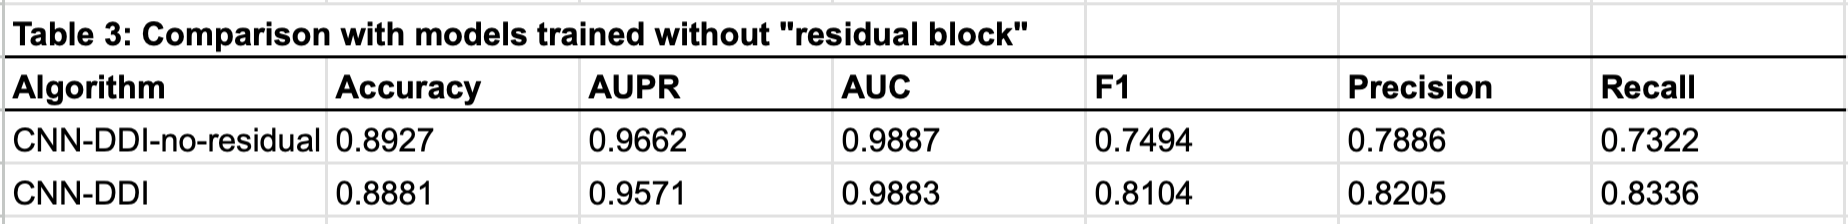

In [ ]:
url_9 = 'https://drive.google.com/uc?id=1EjJsv27emFPwBDX-1KooKT-LIIOpOqjh'
output9 = "Table3.png"
file9 = gdown.download(url_9, output9)
img9=cv2.imread(file9)
cv2_imshow(img9)

#Comparison

**1. Compare our model's performance with other state-of-art models:**
 * We compare our CNN-DDI model with other state-of-art models such as Gradient-Boosted Decision Trees/Random Forest/K-Nearest Neighbors/Logistic Regression, and the result is as belows. From Table 4, we can see that our CNN-DDI model is a clear winner in all performance metrics.

Downloading...
From: https://drive.google.com/uc?id=1zUgTccxccj1XXaVD6q4tkUk7HjlAfl-K
To: /content/Table4.png
100%|██████████| 101k/101k [00:00<00:00, 4.67MB/s]


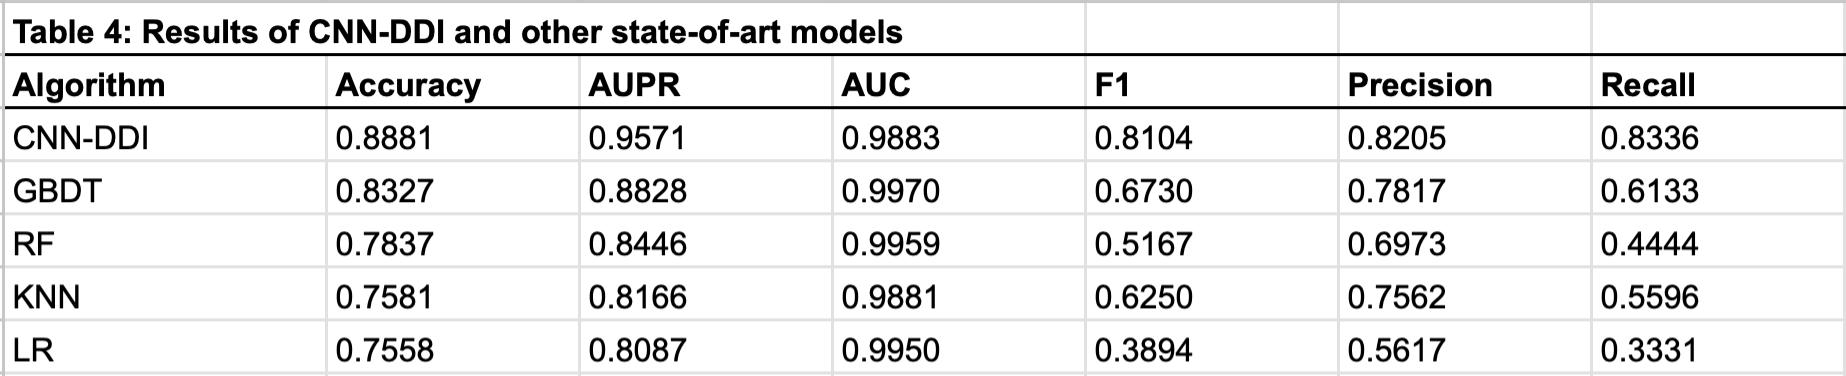

In [ ]:
url_10 = 'https://drive.google.com/uc?id=1zUgTccxccj1XXaVD6q4tkUk7HjlAfl-K'
output10 = "Table4.png"
file10 = gdown.download(url_10, output10)
img10=cv2.imread(file10)
cv2_imshow(img10)

**2. Compare our model with original paper's CNN-DDI and DDIMDL models:**
 * We compare our model with the original paper's CNN-DDI model as well as the DDIMDL model from related work [2].
 * Our CNN-DDI model has accuracy = 0.8881, while the model in the original paper has accuracy = 0.8871. This shows our reproduced model's performance is very similar to the original model proposed in the paper, even with slightly better performance in some metrics.
 * DDIMDL has accuracy = 0.8852, so our model also outperforms DDIMDL.

Downloading...
From: https://drive.google.com/uc?id=1B59_ucTqC5En0kvGG36BVyEi-75pQ_nj
To: /content/Table5.png
100%|██████████| 85.3k/85.3k [00:00<00:00, 3.91MB/s]


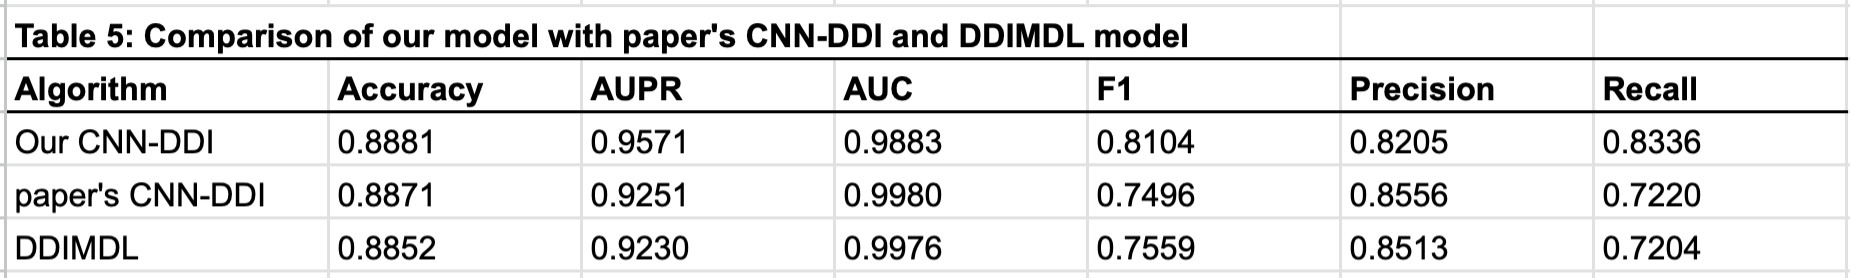

In [ ]:
url_11 = 'https://drive.google.com/uc?id=1B59_ucTqC5En0kvGG36BVyEi-75pQ_nj'
output11 = "Table5.png"
file11 = gdown.download(url_11, output11)
img11=cv2.imread(file11)
cv2_imshow(img11)

# Discussion

 Overall, the paper is reproducible only with additional references to other papers and repositories.


 Here are some of the major challenges we experienced when trying to reproduce the paper:


 * The respository provided by the chosen CNN-DDI paper [1] is https://github.com/YifanDengWHU/DDIMDL. However, this is actually NOT the repository for this paper. Instead,  it is the repository of a different paper, DDIMDL [2], which was referenced by CNN-DDI and done by a different group of authors. This essentially means that we are reproducing a paper with no public repository.


 * With no data and code for CNN-DDI, the only available resource for us to move forward is the DDIMDL repository. We started with a good understanding of DDIMDL paper, got familiar with the data and code in its repository, and reverse engineered the differences between CNN-DDI and DDIMDL. It is beneficial to study more papers in depth, but we struggled quite a bit given the time constraints.


 * Moreover, CNN-DDI paper's content presentation is lacking. Many critical concepts, such as how drug-drug interaction events are defined, how they are related to mechanism and action in the dataset, are not properly explained, and we had to refer to [2] and [3] to confirm our guesses and supplement the understanding of these concepts. Otherwise, it could be very difficult, if not impossible, to make meaningful progress on data modeling and preparation.


 * For data collection, we downloaded additional data from https://go.drugbank.com/, and joined with the existing data available in DDIMDL repository.


To improve the reproducibility of the paper, we would like to suggest the authors to publish their own repository. If this is not possible and readers are only left with a reference paper's repository, then it will be super helpful if the authors can clearly explain the differences and what they did on top of the reference paper.

Even though the original paper has limited reproducibility, our team managed to reproduce all the results in the work and verified the key hypotheses. Through this project, we have gained valuable practical experiences on applying deep learning in healthcare domains. The CNN-DDI model architecture was not difficult to understand and reproduce, but we conquered numerous challenges on data collection/understanding/preparation/processing in order to generate data appropriate to be used as model input. Furthermore, model training and evaluation demanded high performance hardware. We were fortunate that one of our team members has a NVIDIA GPU, which tremendously helped to speed up the process.


# References

1. Original Paper:
  
  Zhang, C., Lu, Y. & Zang, T. CNN-DDI: a learning-based method for predicting drug-drug interactions using convolution neural networks. BMC Bioinformatics 23 (Suppl 1), 88 (2022). https://doi.org/10.1186/s12859-022-04612-2

2. Yifan Deng, Xinran Xu, Yang Qiu, Jingbo Xia, Wen Zhang, Shichao Liu, A multimodal deep learning framework for predicting drug–drug interaction events, Bioinformatics, Volume 36, Issue 15, August 2020, Pages 4316–4322, https://doi.org/10.1093/bioinformatics/btaa501

3. Yang, Z., Tong, K., Jin, S. et al. CNN-Siam: multimodal siamese CNN-based deep learning approach for drug‒drug interaction prediction. BMC Bioinformatics 24, 110 (2023). https://doi.org/10.1186/s12859-023-05242-y
